# **Differenciation of real faces from synthesized ones**

In [ ]:
# For google colab
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# For google colab (or if needed)

! pip install face-recognition

In [ ]:
import os
import random
from face_recognition import face_encodings, load_image_file
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import datasets, transforms, models
import sklearn.metrics as metrics
from PIL import Image
import seaborn as sns
import json
from tqdm import tqdm

## First Analysis

In [ ]:
# Path to set for google colab
# train_path = "drive/MyDrive/small_real-vs-fake/train"

train_path = "small_real-vs-fake/train"

num_images_per_category = 5000


norms = {"real": [], "fake": []}

# Function to calculate the encodings
def process_images(category):
    category_path = os.path.join(train_path, category)
    images = os.listdir(category_path)
    random.shuffle(images)
    selected_images = images[:num_images_per_category]
    s=0

    for img_name in selected_images:
        img_path = os.path.join(category_path, img_name)
        try:
            image = load_image_file(img_path)
            encodings = face_encodings(image)
            if encodings:
                norms[category].append(np.linalg.norm(encodings[0]))
            if s==0:
                print(np.shape(encodings[0]))
                s=1
        except Exception as e:
            print(f"Erreur avec l'image {img_name}: {e}")

# For both real and fake categories
for category in norms.keys():
    process_images(category)

# Graph to compare norms
plt.figure(figsize=(10, 6))
plt.boxplot([norms["real"], norms["fake"]], labels=["Real", "Fake"])
plt.title("Comparaison des normes des vecteurs d'encodage facial")
plt.ylabel("Norme des vecteurs")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


KeyboardInterrupt: 

In [ ]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataloader

In [ ]:
######## Compute the encodings once and store them into a json file

# Path to dataset
# dataset_path = "drive/MyDrive/small_real-vs-fake"
# output_path = "drive/MyDrive/encodings_real-vs-fake"

dataset_path = "small_real-vs-fake"
output_path = "encodings_real-vs-fake"
os.makedirs(output_path, exist_ok=True)

def precalculate_encodings_by_split(dataset_path, output_path):
    """
    Précalcule les encodages des images pour chaque split et classe, et les sauvegarde séparément.

    Args:
        dataset_path (str): Chemin vers le dossier contenant les splits (train, val, test).
        output_path (str): Chemin du dossier de sortie pour sauvegarder les encodages.
    """
    os.makedirs(output_path, exist_ok=True)

    for split in ["train", "valid", "test"]:
        split_path = os.path.join(dataset_path, split)
        print(f"Traitement du split : {split}")

        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if not os.path.isdir(class_path):
                continue

            print(f"  Classe : {class_name}")
            encodings = []
            filenames = []

            for img_name in tqdm(os.listdir(class_path)):
                img_path = os.path.join(class_path, img_name)
                try:
                    image = load_image_file(img_path)
                    encoding = face_encodings(image)

                    if encoding:
                        encodings.append(encoding[0].tolist())
                        filenames.append(img_path)
                except Exception as e:
                    print(f"Erreur avec l'image {img_name}: {e}")


            output_file = os.path.join(output_path, f"{split}_{class_name}_encodings.json")
            with open(output_file, "w") as f:
                json.dump({"filenames": filenames, "encodings": encodings}, f)

            print(f"Encodages pour {split} - {class_name} sauvegardés dans {output_file}")

precalculate_encodings_by_split(dataset_path, output_path)


Traitement du split : train
  Classe : real


  1%|          | 51/5000 [00:11<19:05,  4.32it/s]


KeyboardInterrupt: 

In [ ]:
#Compute statistical repartition of encodings (in order to normalize them)

def compute_featurewise_mean_std(train_loader):

    all_encodings = []


    for _,_,encodings in train_loader:
        all_encodings.append(encodings)

    all_encodings = torch.cat(all_encodings, dim=0)

    mean = torch.mean(all_encodings, dim=0)
    std = torch.std(all_encodings, dim=0)

    return mean, std



In [ ]:
from math import comb


# Path to the dataset folder
dataset_path = "drive/MyDrive/small_real-vs-fake"
output_path = "drive/MyDrive/encodings_real-vs-fake"


# Image transformations
transform = transforms.Compose([ transforms.Resize((64,64)),  # Resize images to 224x224 (adjust as needed)
    transforms.ToTensor(),         # Convert images to tensors
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize (adjust mean/std if needed)
])

class ImageEncodingDataset(Dataset):
    def __init__(self, encodings_file, transform=None, label=None, norm=False, mean=None, std=None):

        with open(encodings_file, "r") as f:
            data = json.load(f)

        self.filenames = data["filenames"]
        self.encodings = torch.tensor(data["encodings"], dtype=torch.float32)
        self.transform = transform
        self.label = label
        self.norm = norm
        self.mean = mean
        self.std = std


        assert len(self.filenames) == len(self.encodings),

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        encoding = self.encodings[idx]
        if self.norm:
            encoding = (encoding - self.mean) / self.std

        if self.label is not None:
            return image, self.label, encoding
        else:
            return image, encoding


train_real_path = os.path.join(output_path,"train_real_encodings.json")
train_fake_path = os.path.join(output_path,"train_fake_encodings.json")
val_real_path = os.path.join(output_path,"valid_real_encodings.json")
val_fake_path = os.path.join(output_path,"valid_fake_encodings.json")
test_real_path = os.path.join(output_path,"test_real_encodings.json")
test_fake_path = os.path.join(output_path,"test_fake_encodings.json")


train_real_dataset = ImageEncodingDataset(train_real_path, transform=transform, label=0)  # 0 = 'real'
train_fake_dataset = ImageEncodingDataset(train_fake_path, transform=transform, label=1)  # 1 = 'fake'
combined_train_dataset = ConcatDataset([train_real_dataset, train_fake_dataset])
train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True)
featurewise_mean, featurewise_std = compute_featurewise_mean_std(train_loader)



train_real_dataset = ImageEncodingDataset(train_real_path, transform=transform, label=0, norm=True, mean=featurewise_mean, std=featurewise_std)  # 0 = 'real'
train_fake_dataset = ImageEncodingDataset(train_fake_path, transform=transform, label=1, norm=True, mean=featurewise_mean, std=featurewise_std)  # 1 = 'fake'
val_real_dataset = ImageEncodingDataset(val_real_path, transform=transform, label=0, norm=True, mean=featurewise_mean, std=featurewise_std)
val_fake_dataset = ImageEncodingDataset(val_fake_path, transform=transform, label=1, norm=True, mean=featurewise_mean, std=featurewise_std)
test_real_dataset = ImageEncodingDataset(test_real_path, transform=transform, label=0, norm=True, mean=featurewise_mean, std=featurewise_std)
test_fake_dataset = ImageEncodingDataset(test_fake_path, transform=transform, label=1, norm=True, mean=featurewise_mean, std=featurewise_std)


combined_val_dataset = ConcatDataset([val_real_dataset, val_fake_dataset])
combined_test_dataset = ConcatDataset([test_real_dataset, test_fake_dataset])
combined_train_dataset = ConcatDataset([train_real_dataset, train_fake_dataset])


train_loader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(combined_val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(combined_test_dataset, batch_size=32, shuffle=False)

class_names = ["real", "fake"]


KeyboardInterrupt: 

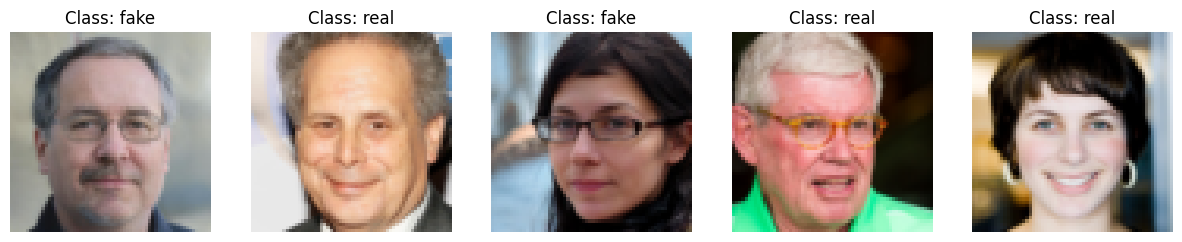

In [ ]:
import matplotlib.pyplot as plt

# Display some sample images
def show_sample(loader):
    data_iter = iter(loader)
    images, labels, encoding = next(data_iter)

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        ax = axes[i]
        img = images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
        img = img * 0.5 + 0.5  # Unnormalize
        ax.imshow(img)
        ax.set_title(f"Class: {class_names[labels[i]]}")
        ax.axis("off")

show_sample(train_loader)


## CNN model

In [ ]:
class RealFakeClassifier(nn.Module):
    def __init__(self, num_channels=3, img_size=64):
        super(RealFakeClassifier, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )

        conv_out_size = (img_size // 4, img_size // 4)
        flat_size = 256 * conv_out_size[0] * conv_out_size[1]

        self.fc = nn.Sequential(
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.conv(x)  # Apply 2D convolutions
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # Fully connected layers
        return x

In [ ]:
# Instantiate the model
model = RealFakeClassifier().to(device)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from tqdm.notebook import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total = 0

        # Training loop
        for images, labels, encoding in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # Ensure labels are (batch_size, 1)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute accuracy
            predictions = torch.sigmoid(outputs) > 0.5
            train_correct += (predictions == labels).sum().item()
            total += labels.size(0)

        train_acc = train_correct / total
        print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_acc:.4f}")

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, encoding in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", leave=False):
                images, labels = images.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Compute accuracy
                predictions = torch.sigmoid(outputs) > 0.5
                val_correct += (predictions == labels).sum().item()
                total += labels.size(0)

        val_acc = val_correct / total
        print(f"Epoch {epoch+1}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_acc:.4f}")


In [ ]:
# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

# for lr in [0.1, 0.01, 0.001, 0.0001]:
#     print(f"Training with learning rate: {lr}")
#     train_model(train_loader, val_loader, lr, num_epochs=3)


Training Epoch 1/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.6835, Train Accuracy: 0.5991


Validation Epoch 1/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1, Val Loss: 0.5997, Val Accuracy: 0.6807


Training Epoch 2/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.6019, Train Accuracy: 0.6752


Validation Epoch 2/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2, Val Loss: 0.5565, Val Accuracy: 0.7177


Training Epoch 3/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.5522, Train Accuracy: 0.7195


Validation Epoch 3/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3, Val Loss: 0.5384, Val Accuracy: 0.7267


Training Epoch 4/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.5016, Train Accuracy: 0.7547


Validation Epoch 4/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4, Val Loss: 0.4801, Val Accuracy: 0.7638


Training Epoch 5/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.4514, Train Accuracy: 0.7858


Validation Epoch 5/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5, Val Loss: 0.4601, Val Accuracy: 0.7878


Training Epoch 6/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.3994, Train Accuracy: 0.8183


Validation Epoch 6/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6, Val Loss: 0.4805, Val Accuracy: 0.7978


Training Epoch 7/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.3362, Train Accuracy: 0.8563


Validation Epoch 7/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7, Val Loss: 0.5360, Val Accuracy: 0.7638


Training Epoch 8/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.2715, Train Accuracy: 0.8855


Validation Epoch 8/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8, Val Loss: 0.4544, Val Accuracy: 0.7978


Training Epoch 9/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.1990, Train Accuracy: 0.9174


Validation Epoch 9/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9, Val Loss: 0.5581, Val Accuracy: 0.7918


Training Epoch 10/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.1585, Train Accuracy: 0.9365


Validation Epoch 10/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10, Val Loss: 0.6439, Val Accuracy: 0.7778


Training Epoch 11/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.1222, Train Accuracy: 0.9541


Validation Epoch 11/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11, Val Loss: 0.6534, Val Accuracy: 0.8078


Training Epoch 12/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.0955, Train Accuracy: 0.9645


Validation Epoch 12/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12, Val Loss: 0.7079, Val Accuracy: 0.7838


Training Epoch 13/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.0822, Train Accuracy: 0.9674


Validation Epoch 13/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13, Val Loss: 0.6637, Val Accuracy: 0.7998


Training Epoch 14/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.0698, Train Accuracy: 0.9767


Validation Epoch 14/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14, Val Loss: 0.7190, Val Accuracy: 0.7818


Training Epoch 15/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.0569, Train Accuracy: 0.9804


Validation Epoch 15/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15, Val Loss: 0.8089, Val Accuracy: 0.8078


Training Epoch 16/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.0569, Train Accuracy: 0.9789


Validation Epoch 16/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16, Val Loss: 0.6969, Val Accuracy: 0.8258


Training Epoch 17/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.0426, Train Accuracy: 0.9837


Validation Epoch 17/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17, Val Loss: 0.9206, Val Accuracy: 0.8018


Training Epoch 18/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.0364, Train Accuracy: 0.9880


Validation Epoch 18/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18, Val Loss: 0.8159, Val Accuracy: 0.8018


Training Epoch 19/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.0485, Train Accuracy: 0.9826


Validation Epoch 19/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19, Val Loss: 0.9069, Val Accuracy: 0.8018


Training Epoch 20/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.0424, Train Accuracy: 0.9852


Validation Epoch 20/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20, Val Loss: 0.8015, Val Accuracy: 0.8008


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, encoding in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            outputs = model(images)
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total *100
    print(f"Test Accuracy: {acc:.2f}%")

evaluate_model(model, test_loader)

Test Accuracy: 80.78%


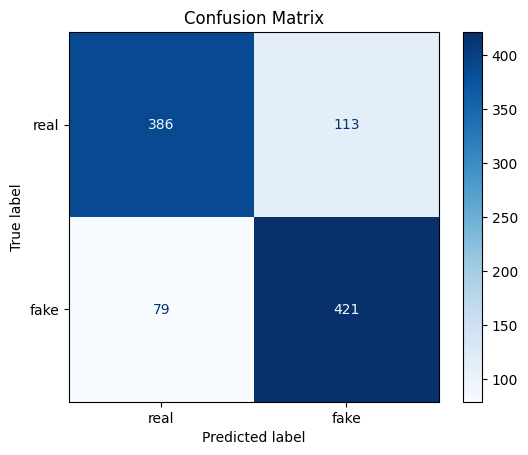

In [ ]:
def compute_confusion_matrix(model, test_loader, classes):
    """
    Computes and plots the confusion matrix for the test dataset.

    Args:
        model: The trained model.
        test_loader: DataLoader for the test set.
    """
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels, encoding in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            predicted = torch.sigmoid(outputs) > 0.5

            # Store labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = metrics.confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Example usage
compute_confusion_matrix(model, test_loader, classes=class_names)

## Model using the encoding

In [ ]:
class RealFakeClassifierEncoded(nn.Module):
    def __init__(self, num_channels=3, img_size=64):
        super(RealFakeClassifierEncoded, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.fc(x)  # Fully connected layers
        return x

In [ ]:
# Instantiate the model
model2 = RealFakeClassifierEncoded().to(device)

# Loss function
criterion2 = nn.BCEWithLogitsLoss()

# Optimizer
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
def train_model_encoded(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total = 0

        # Training loop
        for images, labels, encoding in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            encoding, labels = encoding.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            encoding= encoding.float()  # Ensure labels are (batch_size, 1)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(encoding)

            # Compute loss
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute accuracy
            predictions = torch.sigmoid(outputs) > 0.5
            train_correct += (predictions == labels).sum().item()
            total += labels.size(0)

        train_acc = train_correct / total
        print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_acc:.4f}")

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, encoding in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", leave=False):
                encoding, labels = encoding.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)
                encoding= encoding.float()

                # Forward pass
                outputs = model(encoding)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Compute accuracy
                predictions = torch.sigmoid(outputs) > 0.5
                val_correct += (predictions == labels).sum().item()
                total += labels.size(0)

        val_acc = val_correct / total
        print(f"Epoch {epoch+1}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_acc:.4f}")


In [ ]:
train_model_encoded(model2, train_loader, val_loader, criterion2, optimizer2, num_epochs=20)

Training Epoch 1/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.3000, Train Accuracy: 0.8716


Validation Epoch 1/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1, Val Loss: 0.2640, Val Accuracy: 0.8949


Training Epoch 2/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.2192, Train Accuracy: 0.9141


Validation Epoch 2/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2, Val Loss: 0.2100, Val Accuracy: 0.9109


Training Epoch 3/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.1848, Train Accuracy: 0.9252


Validation Epoch 3/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3, Val Loss: 0.2123, Val Accuracy: 0.9129


Training Epoch 4/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.1568, Train Accuracy: 0.9381


Validation Epoch 4/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4, Val Loss: 0.2014, Val Accuracy: 0.9139


Training Epoch 5/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.1306, Train Accuracy: 0.9511


Validation Epoch 5/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5, Val Loss: 0.2041, Val Accuracy: 0.9219


Training Epoch 6/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.1142, Train Accuracy: 0.9544


Validation Epoch 6/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6, Val Loss: 0.2855, Val Accuracy: 0.8999


Training Epoch 7/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.0936, Train Accuracy: 0.9625


Validation Epoch 7/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7, Val Loss: 0.2533, Val Accuracy: 0.9159


Training Epoch 8/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.0834, Train Accuracy: 0.9687


Validation Epoch 8/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8, Val Loss: 0.2454, Val Accuracy: 0.9039


Training Epoch 9/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.0682, Train Accuracy: 0.9729


Validation Epoch 9/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9, Val Loss: 0.2520, Val Accuracy: 0.9249


Training Epoch 10/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.0545, Train Accuracy: 0.9783


Validation Epoch 10/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10, Val Loss: 0.2747, Val Accuracy: 0.9119


Training Epoch 11/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.0448, Train Accuracy: 0.9834


Validation Epoch 11/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11, Val Loss: 0.3142, Val Accuracy: 0.9169


Training Epoch 12/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.0382, Train Accuracy: 0.9840


Validation Epoch 12/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12, Val Loss: 0.3191, Val Accuracy: 0.9209


Training Epoch 13/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.0363, Train Accuracy: 0.9858


Validation Epoch 13/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13, Val Loss: 0.3420, Val Accuracy: 0.9219


Training Epoch 14/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.0415, Train Accuracy: 0.9844


Validation Epoch 14/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14, Val Loss: 0.3134, Val Accuracy: 0.9259


Training Epoch 15/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.0271, Train Accuracy: 0.9898


Validation Epoch 15/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15, Val Loss: 0.4092, Val Accuracy: 0.9159


Training Epoch 16/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.0269, Train Accuracy: 0.9913


Validation Epoch 16/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16, Val Loss: 0.4169, Val Accuracy: 0.9079


Training Epoch 17/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.0246, Train Accuracy: 0.9910


Validation Epoch 17/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17, Val Loss: 0.4461, Val Accuracy: 0.9109


Training Epoch 18/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.0110, Train Accuracy: 0.9967


Validation Epoch 18/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18, Val Loss: 0.4660, Val Accuracy: 0.9229


Training Epoch 19/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.0403, Train Accuracy: 0.9854


Validation Epoch 19/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19, Val Loss: 0.4578, Val Accuracy: 0.9099


Training Epoch 20/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.0272, Train Accuracy: 0.9897


Validation Epoch 20/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20, Val Loss: 0.3763, Val Accuracy: 0.9289


In [ ]:
# Evaluate test set
def evaluate_model_encoded(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, encoding in test_loader:
            encoding, labels = encoding.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            encoding= encoding.float()
            outputs = model(encoding)
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total *100
    print(f"Test Accuracy: {acc:.2f}%")

evaluate_model_encoded(model2, test_loader)

In [ ]:
def compute_confusion_matrix_encoded(model, test_loader, classes):
    """
    Computes and plots the confusion matrix for the test dataset.

    Args:
        model: The trained model.
        test_loader: DataLoader for the test set.
    """
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels, encoding in test_loader:
            encoding, labels = encoding.to(device), labels.to(device)

            # Forward pass
            outputs = model(encoding)
            predicted = torch.sigmoid(outputs) > 0.5

            # Store labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = metrics.confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Example usage
compute_confusion_matrix_encoded(model2, test_loader, classes=class_names)

## Both images and encoding

In [ ]:
class ImagesEncodingClassifier(nn.Module):
    def __init__(self, num_channels=3, img_size=64, size_encoding=128):
        super(ImagesEncodingClassifier, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )

        conv_out_size = (img_size // 4, img_size // 4)
        flat_size = 256 * conv_out_size[0] * conv_out_size[1] + size_encoding

        self.fc = nn.Sequential(
            nn.Linear(flat_size, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, images, encoding):
        x = self.conv(images)  # Apply 2D convolutions
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.cat((x, encoding), dim=1)  # Concatenate encoding
        x = self.fc(x)  # Fully connected layers
        return x

In [ ]:
# Instantiate the model
model4 = ImagesEncodingClassifier().to(device)

# Loss function
criterion4 = nn.BCEWithLogitsLoss()

# Optimizer
optimizer4 = optim.Adam(model4.parameters(), lr=0.001)

In [ ]:
def train_model_encoded_images(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total = 0

        # Training loop
        for images, labels, encoding in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            encoding, labels, images = encoding.to(device), labels.to(device), images.to(device)
            labels = labels.float().unsqueeze(1)
            encoding= encoding.float()  # Ensure labels are (batch_size, 1)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images, encoding)

            # Compute loss
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Compute accuracy
            predictions = torch.sigmoid(outputs) > 0.5
            train_correct += (predictions == labels).sum().item()
            total += labels.size(0)

        train_acc = train_correct / total
        print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_acc:.4f}")

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, encoding in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", leave=False):
                encoding, labels, images = encoding.to(device), labels.to(device), images.to(device)
                labels = labels.float().unsqueeze(1)
                encoding= encoding.float()

                # Forward pass
                outputs = model(images, encoding)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Compute accuracy
                predictions = torch.sigmoid(outputs) > 0.5
                val_correct += (predictions == labels).sum().item()
                total += labels.size(0)

        val_acc = val_correct / total
        print(f"Epoch {epoch+1}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_acc:.4f}")

In [ ]:
train_model_encoded_images(model4, train_loader, val_loader, criterion4, optimizer4, num_epochs=20)

Training Epoch 1/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.6833, Train Accuracy: 0.6036


Validation Epoch 1/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1, Val Loss: 0.6374, Val Accuracy: 0.6446


Training Epoch 2/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.5795, Train Accuracy: 0.6971


Validation Epoch 2/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2, Val Loss: 0.5169, Val Accuracy: 0.7307


Training Epoch 3/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.5185, Train Accuracy: 0.7451


Validation Epoch 3/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3, Val Loss: 0.5045, Val Accuracy: 0.7528


Training Epoch 4/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.4543, Train Accuracy: 0.7866


Validation Epoch 4/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4, Val Loss: 0.4872, Val Accuracy: 0.7638


Training Epoch 5/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.3884, Train Accuracy: 0.8265


Validation Epoch 5/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5, Val Loss: 0.4043, Val Accuracy: 0.8108


Training Epoch 6/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.3225, Train Accuracy: 0.8570


Validation Epoch 6/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6, Val Loss: 0.3680, Val Accuracy: 0.8388


Training Epoch 7/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.2640, Train Accuracy: 0.8886


Validation Epoch 7/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7, Val Loss: 0.3347, Val Accuracy: 0.8599


Training Epoch 8/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.1976, Train Accuracy: 0.9223


Validation Epoch 8/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8, Val Loss: 0.3623, Val Accuracy: 0.8569


Training Epoch 9/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.1587, Train Accuracy: 0.9354


Validation Epoch 9/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9, Val Loss: 0.3664, Val Accuracy: 0.8609


Training Epoch 10/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.1204, Train Accuracy: 0.9543


Validation Epoch 10/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10, Val Loss: 0.3750, Val Accuracy: 0.8649


Training Epoch 11/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.0919, Train Accuracy: 0.9643


Validation Epoch 11/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11, Val Loss: 0.5226, Val Accuracy: 0.8569


Training Epoch 12/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.0740, Train Accuracy: 0.9722


Validation Epoch 12/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12, Val Loss: 0.4380, Val Accuracy: 0.8629


Training Epoch 13/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.0608, Train Accuracy: 0.9779


Validation Epoch 13/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13, Val Loss: 0.4542, Val Accuracy: 0.8729


Training Epoch 14/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.0538, Train Accuracy: 0.9808


Validation Epoch 14/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14, Val Loss: 0.5304, Val Accuracy: 0.8599


Training Epoch 15/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.0459, Train Accuracy: 0.9843


Validation Epoch 15/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15, Val Loss: 0.5804, Val Accuracy: 0.8609


Training Epoch 16/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.0427, Train Accuracy: 0.9842


Validation Epoch 16/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16, Val Loss: 0.4155, Val Accuracy: 0.8789


Training Epoch 17/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.0379, Train Accuracy: 0.9860


Validation Epoch 17/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17, Val Loss: 0.4128, Val Accuracy: 0.8719


Training Epoch 18/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.0351, Train Accuracy: 0.9884


Validation Epoch 18/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18, Val Loss: 0.5252, Val Accuracy: 0.8559


Training Epoch 19/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.0310, Train Accuracy: 0.9890


Validation Epoch 19/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19, Val Loss: 0.5618, Val Accuracy: 0.8599


Training Epoch 20/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.0206, Train Accuracy: 0.9921


Validation Epoch 20/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20, Val Loss: 0.5429, Val Accuracy: 0.8729


In [ ]:
# Evaluate test set
def evaluate_model_encoded_images(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    confusion_matrix = np.zeros((2, 2))
    with torch.no_grad():
        for images, labels, encoding in test_loader:
            encoding, labels, images = encoding.to(device), labels.to(device), images.to(device)
            labels = labels.float().unsqueeze(1)
            encoding= encoding.float()
            outputs = model(images,encoding)
            predicted = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total *100
    print(f"Test Accuracy: {acc:.2f}%")

evaluate_model_encoded_images(model4, test_loader)

Test Accuracy: 87.99%


Confusion Matrix:
 [[412  87]
 [ 33 467]]


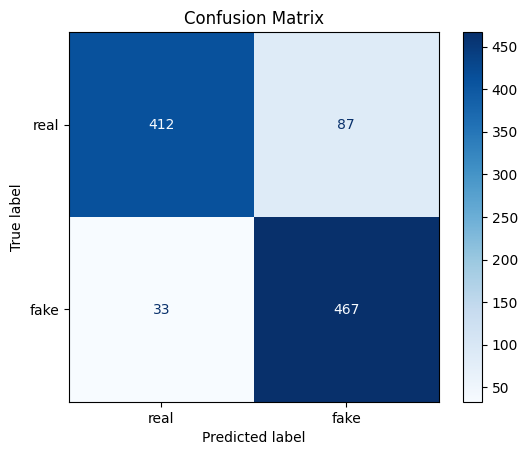

In [ ]:
def compute_confusion_matrix_encoded_images(model, test_loader, classes):
    """
    Computes and plots the confusion matrix for the test dataset.

    Args:
        model: The trained model.
        test_loader: DataLoader for the test set.
    """
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels, encoding in test_loader:
            encoding, labels, images = encoding.to(device), labels.to(device), images.to(device)

            # Forward pass
            outputs = model(images, encoding)
            predicted = torch.sigmoid(outputs) > 0.5

            # Store labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = metrics.confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Example usage
compute_confusion_matrix_encoded_images(model4, test_loader, classes=class_names)

## With Resnet50

In [ ]:
# Load Pre-trained ResNet50
model3 = models.resnet50(pretrained=True)

# Modify the Final Fully Connected Layer
num_ftrs = model3.fc.in_features
model3.fc = nn.Linear(num_ftrs, 1)  # 2 classes for binary classification

# Move Model to GPU if available
model3 = model3.to(device)

# Loss Function and Optimizer
criterion3 = nn.BCEWithLogitsLoss()  # Use CrossEntropy for binary classification
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)


# Train the Model
train_model(model3, train_loader, val_loader, criterion3, optimizer3, num_epochs=20)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training Epoch 1/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.5504, Train Accuracy: 0.7229


Validation Epoch 1/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1, Val Loss: 0.4414, Val Accuracy: 0.7958


Training Epoch 2/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.4106, Train Accuracy: 0.8103


Validation Epoch 2/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2, Val Loss: 0.5142, Val Accuracy: 0.7668


Training Epoch 3/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.3283, Train Accuracy: 0.8604


Validation Epoch 3/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3, Val Loss: 0.3878, Val Accuracy: 0.8228


Training Epoch 4/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.2432, Train Accuracy: 0.8984


Validation Epoch 4/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4, Val Loss: 0.3159, Val Accuracy: 0.8709


Training Epoch 5/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.1914, Train Accuracy: 0.9213


Validation Epoch 5/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5, Val Loss: 0.3326, Val Accuracy: 0.8749


Training Epoch 6/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.1540, Train Accuracy: 0.9395


Validation Epoch 6/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6, Val Loss: 0.3390, Val Accuracy: 0.8689


Training Epoch 7/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.1361, Train Accuracy: 0.9459


Validation Epoch 7/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7, Val Loss: 0.3926, Val Accuracy: 0.8759


Training Epoch 8/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.1046, Train Accuracy: 0.9621


Validation Epoch 8/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8, Val Loss: 0.3443, Val Accuracy: 0.8749


Training Epoch 9/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.0970, Train Accuracy: 0.9618


Validation Epoch 9/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9, Val Loss: 0.4154, Val Accuracy: 0.8809


Training Epoch 10/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.0908, Train Accuracy: 0.9657


Validation Epoch 10/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10, Val Loss: 0.4287, Val Accuracy: 0.8488


Training Epoch 11/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.0780, Train Accuracy: 0.9710


Validation Epoch 11/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11, Val Loss: 0.3955, Val Accuracy: 0.8919


Training Epoch 12/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.0688, Train Accuracy: 0.9750


Validation Epoch 12/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12, Val Loss: 0.3686, Val Accuracy: 0.8929


Training Epoch 13/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.0703, Train Accuracy: 0.9737


Validation Epoch 13/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13, Val Loss: 0.4113, Val Accuracy: 0.8579


Training Epoch 14/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.0605, Train Accuracy: 0.9744


Validation Epoch 14/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14, Val Loss: 0.6050, Val Accuracy: 0.8579


Training Epoch 15/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.0686, Train Accuracy: 0.9746


Validation Epoch 15/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15, Val Loss: 0.3752, Val Accuracy: 0.8889


Training Epoch 16/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.0443, Train Accuracy: 0.9831


Validation Epoch 16/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16, Val Loss: 0.3532, Val Accuracy: 0.8919


Training Epoch 17/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.0477, Train Accuracy: 0.9825


Validation Epoch 17/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17, Val Loss: 0.3356, Val Accuracy: 0.9169


Training Epoch 18/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.0332, Train Accuracy: 0.9867


Validation Epoch 18/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18, Val Loss: 0.4946, Val Accuracy: 0.8719


Training Epoch 19/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.0492, Train Accuracy: 0.9828


Validation Epoch 19/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19, Val Loss: 0.4332, Val Accuracy: 0.8909


Training Epoch 20/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.0393, Train Accuracy: 0.9858


Validation Epoch 20/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20, Val Loss: 0.4373, Val Accuracy: 0.8629


In [ ]:
evaluate_model(model3, test_loader)

Test Accuracy: 86.29%


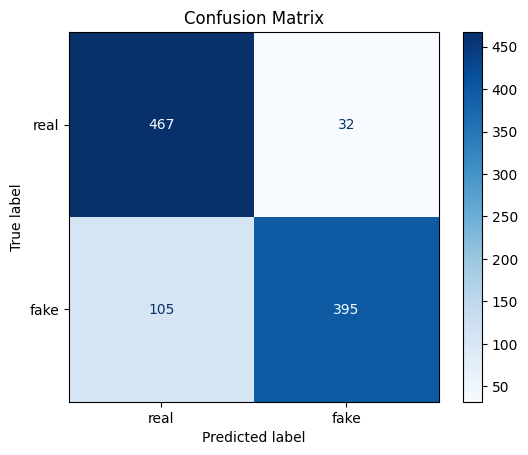

In [ ]:
compute_confusion_matrix(model3, test_loader, classes=class_names)

## Resnet50 + encoding

In [ ]:
class EncodingImageClassifier(nn.Module):
    def __init__(self, encoding_dim=128, image_feature_dim=512):
        super(EncodingImageClassifier, self).__init__()

        # Image feature extractor (pretrained ResNet18 backbone)
        self.image_extractor = models.resnet50(pretrained=True)
        num_ftrs = self.image_extractor.fc.in_features
        self.image_extractor.fc = nn.Identity()  # Remove the classification head

        self.fc = nn.Sequential(
            nn.Linear(num_ftrs+encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, images, encodings):
        # Extract image features
        img_features = self.image_extractor(images)

        # Combine both feature vectors
        combined = torch.cat((img_features, encodings), dim=1)

        # Classification
        x =self.fc(combined)
        return x


In [ ]:
# Instantiate the model
model5 = EncodingImageClassifier().to(device)

# Loss function
criterion5 = nn.BCEWithLogitsLoss()

# Optimizer
optimizer5 = optim.Adam(model5.parameters(), lr=0.001)

In [ ]:
train_model_encoded_images(model5, train_loader, val_loader, criterion5, optimizer5, num_epochs=20)

Training Epoch 1/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.3862, Train Accuracy: 0.8272


Validation Epoch 1/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1, Val Loss: 10.4869, Val Accuracy: 0.7317


Training Epoch 2/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.2906, Train Accuracy: 0.8712


Validation Epoch 2/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2, Val Loss: 0.3228, Val Accuracy: 0.8899


Training Epoch 3/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.2468, Train Accuracy: 0.8960


Validation Epoch 3/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3, Val Loss: 0.4779, Val Accuracy: 0.8789


Training Epoch 4/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.2077, Train Accuracy: 0.9173


Validation Epoch 4/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4, Val Loss: 0.2710, Val Accuracy: 0.9039


Training Epoch 5/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.1792, Train Accuracy: 0.9261


Validation Epoch 5/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5, Val Loss: 0.2264, Val Accuracy: 0.9069


Training Epoch 6/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.1414, Train Accuracy: 0.9460


Validation Epoch 6/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6, Val Loss: 0.2586, Val Accuracy: 0.9039


Training Epoch 7/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.1224, Train Accuracy: 0.9545


Validation Epoch 7/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7, Val Loss: 0.2573, Val Accuracy: 0.8989


Training Epoch 8/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 8, Train Loss: 0.0951, Train Accuracy: 0.9655


Validation Epoch 8/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8, Val Loss: 0.2648, Val Accuracy: 0.9039


Training Epoch 9/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 9, Train Loss: 0.0789, Train Accuracy: 0.9701


Validation Epoch 9/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9, Val Loss: 0.2776, Val Accuracy: 0.9129


Training Epoch 10/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 10, Train Loss: 0.0648, Train Accuracy: 0.9753


Validation Epoch 10/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10, Val Loss: 0.3122, Val Accuracy: 0.9179


Training Epoch 11/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 11, Train Loss: 0.0479, Train Accuracy: 0.9823


Validation Epoch 11/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 11, Val Loss: 0.3154, Val Accuracy: 0.9149


Training Epoch 12/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 12, Train Loss: 0.0443, Train Accuracy: 0.9837


Validation Epoch 12/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 12, Val Loss: 0.3699, Val Accuracy: 0.9169


Training Epoch 13/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 13, Train Loss: 0.0397, Train Accuracy: 0.9849


Validation Epoch 13/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 13, Val Loss: 0.3391, Val Accuracy: 0.9139


Training Epoch 14/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 14, Train Loss: 0.0315, Train Accuracy: 0.9893


Validation Epoch 14/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 14, Val Loss: 0.3804, Val Accuracy: 0.9129


Training Epoch 15/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 15, Train Loss: 0.0417, Train Accuracy: 0.9867


Validation Epoch 15/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 15, Val Loss: 0.4159, Val Accuracy: 0.9139


Training Epoch 16/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 16, Train Loss: 0.0224, Train Accuracy: 0.9917


Validation Epoch 16/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 16, Val Loss: 0.4511, Val Accuracy: 0.9219


Training Epoch 17/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 17, Train Loss: 0.0188, Train Accuracy: 0.9926


Validation Epoch 17/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 17, Val Loss: 0.4449, Val Accuracy: 0.9179


Training Epoch 18/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 18, Train Loss: 0.0210, Train Accuracy: 0.9925


Validation Epoch 18/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 18, Val Loss: 0.4643, Val Accuracy: 0.9169


Training Epoch 19/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 19, Train Loss: 0.0126, Train Accuracy: 0.9963


Validation Epoch 19/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 19, Val Loss: 0.5263, Val Accuracy: 0.9149


Training Epoch 20/20:   0%|          | 0/312 [00:00<?, ?it/s]

Epoch 20, Train Loss: 0.0127, Train Accuracy: 0.9956


Validation Epoch 20/20:   0%|          | 0/32 [00:00<?, ?it/s]

Epoch 20, Val Loss: 0.4559, Val Accuracy: 0.9169


In [ ]:
evaluate_model_encoded_images(model5, test_loader)

Test Accuracy: 91.69%


Confusion Matrix:
 [[468  31]
 [ 52 448]]


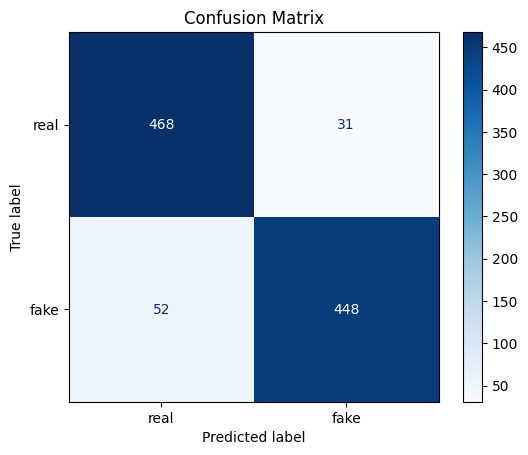

In [ ]:
compute_confusion_matrix_encoded_images(model5, test_loader, classes=class_names)